## 可选问题 - 预测北京房价

（本题结果不影响项目是否通过）通过上面的实践，相信你对机器学习的一些常用概念有了很好的领悟和掌握。但利用70年代的波士顿房价数据进行建模的确对我们来说意义不是太大。现在你可以把你上面所学应用到北京房价数据集中 `bj_housing.csv`。

免责声明：考虑到北京房价受到宏观经济、政策调整等众多因素的直接影响，预测结果仅供参考。

这个数据集的特征有：
- Area：房屋面积，平方米
- Room：房间数，间
- Living: 厅数，间
- School: 是否为学区房，0或1
- Year: 房屋建造时间，年
- Floor: 房屋所处楼层，层

目标变量：
- Value: 房屋人民币售价，万

你可以参考上面学到的内容，拿这个数据集来练习数据分割与重排、定义衡量标准、训练模型、评价模型表现、使用网格搜索配合交叉验证对参数进行调优并选出最佳参数，比较两者的差别，最终得出最佳模型对验证集的预测分数。

## 一、导入数据

In [1]:
# 载入此项目所需要的库
import numpy as np
import pandas as pd
import visuals as vs
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor

# 检查Python版本
from sys import version_info
if version_info.major !=2 and version_info.minor != 7:
    raise Exception('请使用Python2.7来完成此项目')
    
# 让plot结果在notebook中显示
%matplotlib inline

In [2]:
# 载入jupyter notebook主题库关于plot的模块
from jupyterthemes import jtplot
jtplot.style(ticks=True)  # 优化这个主题下notebook中plot的显示

In [3]:
# 载入北京房价数据
data = pd.read_csv('bj_housing.csv')
prices = data['Value']
features = data.drop('Value', axis=1)

print 'BeiJing housing dataset has {} data points with {} variables each.'.format(*data.shape)

BeiJing housing dataset has 9999 data points with 7 variables each.


## 二、分析数据

In [4]:
# 计算价格的最小值、最大值、平均值、中值、标准差
minimum_price = np.min(prices)
maximum_price = np.max(prices)
mean_price    = np.mean(prices)
median_price  = np.median(prices)
std_price     = np.std(prices)

print 'Statistics for BeiJing housing dataset:\n'
print 'Minimum price:${:,.2f}'.format(minimum_price)
print 'Maximum price:${:,.2f}'.format(maximum_price)
print 'Mean price:${:,.2f}'.format(mean_price)
print 'Median price:${:,.2f}'.format(median_price)
print 'Standard deviation of prices:${:,.2f}'.format(std_price)

Statistics for BeiJing housing dataset:

Minimum price:$66.00
Maximum price:$7,450.00
Mean price:$342.08
Median price:$280.00
Standard deviation of prices:$259.39


In [5]:
# 将数据分割与重排为训练集和测试集

X_train, X_test, y_train, y_test = train_test_split(features, prices, train_size=0.8, random_state=42)

## 三、模型衡量标准

In [6]:
# 用决定系数R^2来量化模型的表现

def performance_metric(y_true, y_predict):
    '''计算并返回预测值相比于真实值的分数'''
    
    score = r2_score(y_true, y_predict)
    
    return score

## 四、分析模型的表现

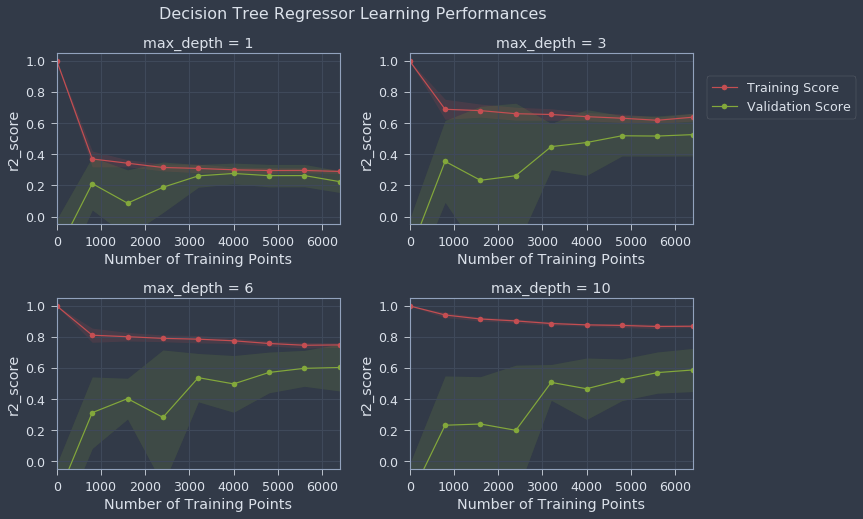

In [7]:
# 根据不同的训练集大小和最大深度，生成学习曲线
vs.ModelLearning(X_train, y_train)

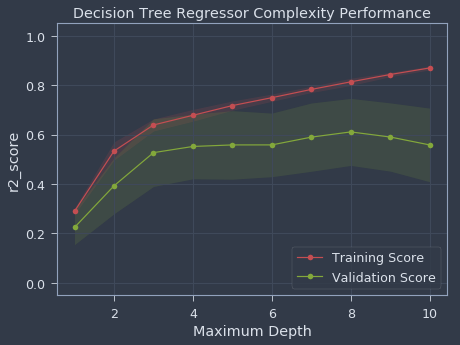

In [8]:
# 根据不同的最大深度参数，生成复杂度曲线
vs.ModelComplexity(X_train, y_train)

## 五、训练最优模型

In [9]:
# 使用决策树算法训练一个模型，并且用网格搜索交叉验证法训练这个模型，以找到最佳的max_depth参数

def fit_model(X, y):
    '''基于输入数据[X,y]，利用网格搜索交叉验证找到最优的决策树模型'''
    
    cross_validator = KFold()
    regressor = DecisionTreeRegressor()
    params = dict(max_depth = np.arange(1, 11))
    scoring_fnc = make_scorer(performance_metric)
    
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cross_validator)
    grid = grid.fit(X,y)  # 基于数据[X,y],进行网格搜索交叉验证
    
    return grid.best_estimator_

In [10]:
# 基于训练数据，获得最优模型
optimal_reg = fit_model(X_train, y_train)

# 输出最优模型的'max_depth'参数
print 'Parameter "max_depth" is  {} for the optimal model.'.format(optimal_reg.get_params()['max_depth'])

Parameter "max_depth" is  3 for the optimal model.


## 六、做出预测

In [11]:
# 用最优模型在整个测试数据上进行预测，并计算决定系数R^2的值

predict_price = optimal_reg.predict(X_test)
r2 = performance_metric(y_test, predict_price)

print 'Optimal model has R^2 score {:.2f} on test data'.format(r2)

Optimal model has R^2 score 0.60 on test data


In [12]:
# 没有使用网格搜索交叉验证法对模型进行优化情况下，计算R^2的值，用来比较

reg = DecisionTreeRegressor().fit(X_train, y_train)
pre_price = reg.predict(X_test)
r2 = performance_metric(y_test, pre_price)
r2

0.57710654231923941

最优模型在测试集上的决定系数为0.60，这个结果偏低  
没有使用网格搜索交叉验证法的情况下，决定系数为0.577，比优化后的只低一点点，可见优化后的模型表现并不好   
改进措施：   
在增加训练数据量的基础上，增加模型的复杂度，有利于改善模型的表现。

In [13]:
# 模型健壮性
client_data = [[110, 3, 2, 1, 2009, 20]]

vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $411.64
Trial 2: $437.03
Trial 3: $437.38
Trial 4: $365.36
Trial 5: $399.74
Trial 6: $354.45
Trial 7: $406.30
Trial 8: $481.22
Trial 9: $401.41
Trial 10: $418.23

Range in prices: $126.77


此模型不具备足够的健壮性来保证预测的一致性。

## 问题 - 北京房价预测
你成功的用新的数据集构建了模型了吗？他能对测试数据进行验证吗？它的表现是否符合你的预期？交叉验证是否有助于提升你模型的表现？

**提示：**如果你是从零开始构建机器学习的代码会让你一时觉得无从下手。这时不要着急，你要做的只是查看之前写的代码，把每一行都看明白，然后逐步构建你的模型。当中遇到什么问题也可以在我们论坛寻找答案。也许你会发现你所构建的模型的表现并没有达到你的预期，这说明机器学习并非是一项简单的任务，构建一个表现良好的模型需要长时间的研究和测试。这也是我们接下来的课程中会逐渐学到的。

## 问题 - 回答
成功的用新的数据集构建了模型  
可以对测试数据进行验证  
模型的表现并不符合我的预期   
交叉验证有助于提升模型的表现（此例中提升的效果并不明显）  